In [1]:
pip install torch torchvision matplotlib scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score


In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [8]:
epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    train_losses.append(running_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.2f}, Accuracy: {accuracy:.2f}")


Epoch 1/5, Loss: 1353.54, Accuracy: 0.39
Epoch 2/5, Loss: 1345.36, Accuracy: 0.40
Epoch 3/5, Loss: 1338.84, Accuracy: 0.40
Epoch 4/5, Loss: 1335.96, Accuracy: 0.40
Epoch 5/5, Loss: 1336.86, Accuracy: 0.40


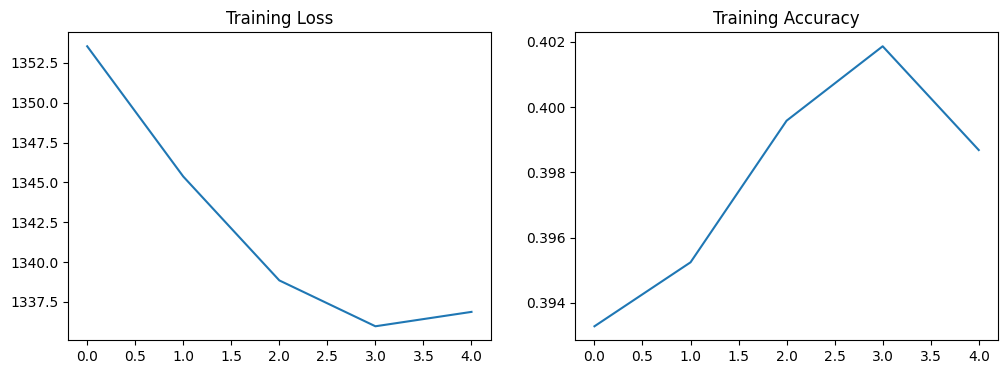

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")

plt.show()


In [10]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))


Accuracy: 0.4215
              precision    recall  f1-score   support

           0       0.42      0.51      0.46      1000
           1       0.53      0.45      0.49      1000
           2       0.38      0.29      0.33      1000
           3       0.44      0.17      0.24      1000
           4       0.39      0.47      0.43      1000
           5       0.36      0.48      0.41      1000
           6       0.40      0.61      0.49      1000
           7       0.48      0.42      0.45      1000
           8       0.39      0.57      0.46      1000
           9       0.60      0.25      0.35      1000

    accuracy                           0.42     10000
   macro avg       0.44      0.42      0.41     10000
weighted avg       0.44      0.42      0.41     10000



In [11]:
torch.save(model.state_dict(), "cifar10_resnet18.pth")

In [12]:
model.load_state_dict(torch.load("cifar10_resnet18.pth"))
model.eval()

def predict(image):
    image = image.unsqueeze(0).to(device)
    output = model(image)
    _, pred = torch.max(output, 1)
    return pred.item()